In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error


In [2]:
# Load the dataset
stock_data = pd.read_csv(r"E:\movies\Hollywood\archive (3)\EW-MAX.csv")

# Display the first few rows of the dataset
print(stock_data.head())

# Preprocess stock data
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)
stock_data = stock_data[['Close']]  # Assuming 'Close' is the target column

# Handle missing values if any
stock_data = stock_data.dropna()


        Date      Open      High       Low     Close  Adj_Close   Volume
0  2000/3/27  3.812500  4.156250  3.812500  4.125000   4.125000  3675600
1  2000/3/28  4.125000  4.125000  4.000000  4.015625   4.015625  1077600
2  2000/3/29  4.000000  4.031250  3.953125  4.000000   4.000000   437200
3  2000/3/30  4.000000  4.000000  3.843750  3.843750   3.843750  1883600
4  2000/3/31  3.734375  3.734375  3.390625  3.390625   3.390625  7931600


In [3]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)


In [4]:
# Create training and testing datasets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]


In [5]:
# Function to create dataset for LSTM
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [6]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [7]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=1, verbose=2)


3412/3412 - 77s - loss: 2.3329e-04 - 77s/epoch - 23ms/step


In [8]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))

print(f'Training RMSE: {train_score:.2f}')
print(f'Testing RMSE: {test_score:.2f}')


25/25 [==============================] - 0s 15ms/step
Training RMSE: 0.93
Testing RMSE: 3.05


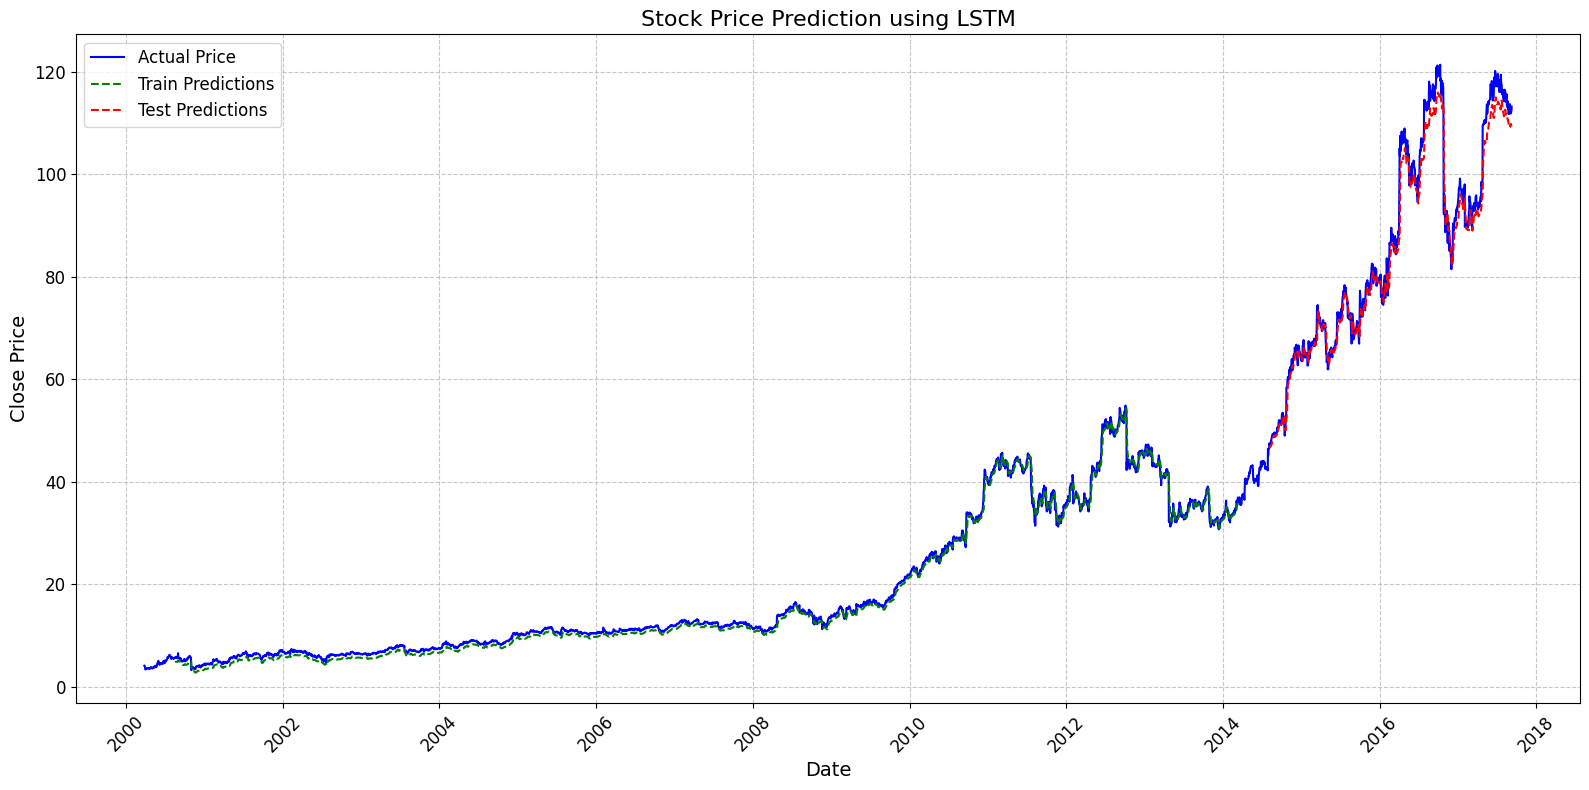

In [9]:
# Plotting
plt.figure(figsize=(16, 8))

# Plot actual data
plt.plot(stock_data.index, stock_data['Close'], color='blue', label='Actual Price')

# Plot training predictions
plt.plot(stock_data.index[time_step:len(train_predict) + time_step], train_predict, color='green', linestyle='--', label='Train Predictions')

# Plot test predictions
plt.plot(stock_data.index[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1], test_predict, color='red', linestyle='--', label='Test Predictions')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.title('Stock Price Prediction using LSTM', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [10]:
# Function to predict the next closing price
def predict_next_close(model, data, scaler, time_step=100):
    last_data = data[-time_step:]
    last_data = last_data.reshape((1, time_step, 1))
    predicted_price = model.predict(last_data)
    predicted_price = scaler.inverse_transform(predicted_price)
    return predicted_price[0][0]

# Example usage of the prediction function
next_close_price = predict_next_close(model, scaled_data, scaler, time_step)
print(f"Predicted next close price: ${next_close_price:.2f}")

# Example function showing how to use prediction repeatedly
def example_prediction():
    next_close_price = predict_next_close(model, scaled_data, scaler, time_step)
    print(f"Predicted next close price: ${next_close_price:.2f}")

    # Simulating adding new data for future predictions
    new_data = np.array([[next_close_price]])
    new_scaled_data = scaler.transform(new_data)
    updated_scaled_data = np.append(scaled_data, new_scaled_data, axis=0)

    next_next_close_price = predict_next_close(model, updated_scaled_data, scaler, time_step)
    print(f"Predicted next next close price: ${next_next_close_price:.2f}")

# Run the example function
example_prediction()


1/1 [==============================] - 0s 26ms/step
Predicted next close price: $109.35
1/1 [==============================] - 0s 23ms/step
Predicted next close price: $109.35
1/1 [==============================] - 0s 20ms/step
Predicted next next close price: $108.48


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
